# FSII Analysis with ViT and Dynamic Patch Grid

This notebook demonstrates how to:
1. Split an input image into a patch grid corresponding to a Vision Transformer.  
2. Define a masking function that applies a gray mask to selected patches.  
3. Compute model logits on masked images for a chosen target class.  
4. Approximate 2nd-order Faithful Shapley Interaction Indices (FSII) with SHAPIQ.  
5. Display the top-5 interacting patch pairs on the image.

In [1]:
from IPython.display import display
import sys
import torch
import numpy as np
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image, ImageDraw
import requests
from io import BytesIO
from typing import Union
from shapiq.approximator.regression import RegressionFSII

## 1. Parameters & Device

In [2]:
# model & image
model_name = "google/vit-base-patch32-384"
image_url  = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cats.png"

# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)
if device.type == "cuda":
    print(" CUDA device name:", torch.cuda.get_device_name())

Running on device: cuda
 CUDA device name: NVIDIA GeForce RTX 3060 Laptop GPU


## 2. Load Model & Grid Configuration

In [3]:
# load ViT processor & model
processor = ViTImageProcessor.from_pretrained(model_name)
model     = ViTForImageClassification.from_pretrained(model_name).to(device).eval()

# derive patch grid from model config
patch_size        = model.config.patch_size   # e.g. 32
image_size        = model.config.image_size   # e.g. 384
n_patches_per_row = image_size // patch_size  # e.g. 12
n_patches         = n_patches_per_row ** 2    # e.g. 144

# cell dimensions
cell_h = cell_w = patch_size

## 3. Helper Functions

In [4]:
def mask_image_grid(img: Image.Image, coalition: Union[np.ndarray, list]) -> Image.Image:
    """
    Apply a gray mask to patches where coalition[i] == False.
    coalition: boolean array of length n_patches.
    """
    arr  = np.array(img.resize((image_size, image_size))).copy()
    coal = np.asarray(coalition, dtype=bool)
    for i, keep in enumerate(coal):
        if not keep:
            r, c = divmod(i, n_patches_per_row)
            y1, y2 = r * cell_h, (r + 1) * cell_h
            x1, x2 = c * cell_w, (c + 1) * cell_w
            arr[y1:y2, x1:x2] = 128
    return Image.fromarray(arr)

In [5]:
def draw_grid(img: Image.Image):
    """Overlay the patch grid with indices on the image."""
    draw = ImageDraw.Draw(img)
    for r in range(n_patches_per_row):
        for c in range(n_patches_per_row):
            x1, y1 = c*cell_w, r*cell_h
            x2, y2 = x1+cell_w, y1+cell_h
            draw.rectangle([x1, y1, x2, y2], outline="gray", width=1)
            idx = r * n_patches_per_row + c
            draw.text((x1+2, y1+2), str(idx), fill="gray")
    display(img)


In [6]:
def value_function(coalitions: np.ndarray) -> np.ndarray:
    """
    Expects array of shape (n_coalitions, n_patches).
    Returns logits[target_class] for each coalition.
    """
    out = []
    for coalition in coalitions:
        masked = mask_image_grid(image, coalition)
        batch  = processor(images=masked, return_tensors="pt").to(device)
        with torch.no_grad():
            logit = model(**batch).logits[0, predicted_class].item()
        out.append(logit)
    return np.array(out)

## 4. Main Execution

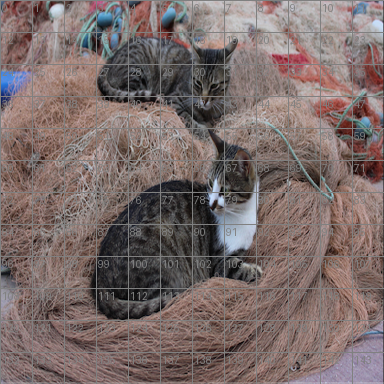

Predicted class: tabby, tabby cat
Logit (full) : 6.84
Logit (empty): -0.05

Top-5 FSII 2nd-Order:
 1. Patch-Pair (1, 33) → FSII = 304206403321.2372
 2. Patch-Pair (0, 28) → FSII = -253499338586.3487
 3. Patch-Pair (1, 11) → FSII = -250925402504.3220
 4. Patch-Pair (0, 43) → FSII = 241328770432.3435
 5. Patch-Pair (0, 75) → FSII = -219488893286.4660


In [7]:
def main():
    global image, predicted_class

    # 1) Load image
    resp  = requests.get(image_url)
    image = Image.open(BytesIO(resp.content)).convert("RGB").resize((image_size, image_size))

    # 2) Show patch grid
    draw_grid(image.copy())

    # 3) Determine target class on full image
    inputs = processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    predicted_class = int(logits.argmax(-1))
    print(f"Predicted class: {model.config.id2label[predicted_class]}")

    # 4) Quick check: full vs empty
    full  = value_function([np.ones(n_patches, bool)])[0]
    empty = value_function([np.zeros(n_patches, bool)])[0]
    print(f"Logit (full) : {full:.2f}")
    print(f"Logit (empty): {empty:.2f}")

    # 5) FSII approximation (no custom sampling_weights, no monkey-patch)
    approximator = RegressionFSII(
        n=n_patches,
        max_order=2,
        pairing_trick=False,
        random_state=42
    )
    result = approximator.approximate(
        budget=300,
        game=value_function
    )

    # 6) Extract top-5 2nd-order interactions
    fsii_map = result.dict_values
    second  = {p: v for p, v in fsii_map.items() if len(p)==2}
    top5    = sorted(second.items(), key=lambda kv: abs(kv[1]), reverse=True)[:5]
    print("\nTop-5 FSII 2nd-Order:")
    for rank, (pair, val) in enumerate(top5, start=1):
        print(f" {rank}. Patch-Pair {pair} → FSII = {val:.4f}")

    # 7) Visualize top pairs
    colors = ["red","blue","green","yellow","purple"]
    vis    = image.copy().resize((image_size,image_size))
    draw   = ImageDraw.Draw(vis)
    drawn  = set()
    for idx,(i,j) in enumerate([p for p,_ in top5]):
        col = colors[idx]
        for patch in (i,j):
            if patch in drawn: continue
            drawn.add(patch)
            r, c = divmod(patch, n_patches_per_row)
            x1, y1 = c*cell_w, r*cell_h
            x2, y2 = x1+cell_w, y1+cell_h
            draw.rectangle([x1,y1,x2,y2], outline=col, width=3)
            draw.text((x1+2,y1+2), str(patch), fill=col)
    display(vis)

if __name__ == "__main__":
    main()